In [1]:
# imports
import tensorflow as tf
import numpy as np
from six.moves import cPickle as pickle
from scaledalexnet import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# load data

testing_file = '../datasets/traffic-signs-data/test.p'
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_test, y_test = test['features'], test['labels']

print(X_test.shape)
print(y_test.shape)

pixel_depth = 255.0

X_test_norm =  (X_test.astype(np.float32) - (pixel_depth * 0.5)) / (pixel_depth * 0.5)

(12630, 32, 32, 3)
(12630,)


In [3]:
ens = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # model numbers to join the ensemble average
ens_path = 'saved-salexnet-aug-eq-n-ens' # path for saved models
scores_file_name = 'scores.pkl' # file name to save scores

num_labels = 43
batch_size = 12630

salexnet = ScaledAlexNet(num_labels, image_size=32, batch_size=batch_size)

def pickle_model_scores(X, model, ens, ens_path, scores_file_name):
    """Save scores for each model.
    
    Arguments:
        X: features of test dataset.
        ens: a list of model numbers to join the ensemble average.
        ens_path: (string) saved session path (not including the last 
                  ens number).
        scores_file: file name to save the scores.
    """
    
    model.init_model()
    saver = tf.train.Saver()
    
    for i in ens:
        with tf.Session() as sess:
            # restore session
            saver.restore(sess, ens_path + str(i) + '/best-model-session')
            # compute scores
            scores = model.get_class_scores(X, sess)
            with open(ens_path + str(i) + '/' + scores_file_name, mode='wb') as f:
                pickle.dump(scores, f)
            print('scores for model ' + str(i) + ' saved.')

In [4]:
pickle_model_scores(X_test_norm, salexnet, ens, ens_path, scores_file_name)

INFO:tensorflow:Restoring parameters from saved-salexnet-aug-eq-n-ens1/best-model-session
scores for model 1 saved.
INFO:tensorflow:Restoring parameters from saved-salexnet-aug-eq-n-ens2/best-model-session
scores for model 2 saved.
INFO:tensorflow:Restoring parameters from saved-salexnet-aug-eq-n-ens3/best-model-session
scores for model 3 saved.
INFO:tensorflow:Restoring parameters from saved-salexnet-aug-eq-n-ens4/best-model-session
scores for model 4 saved.
INFO:tensorflow:Restoring parameters from saved-salexnet-aug-eq-n-ens5/best-model-session
scores for model 5 saved.
INFO:tensorflow:Restoring parameters from saved-salexnet-aug-eq-n-ens6/best-model-session
scores for model 6 saved.
INFO:tensorflow:Restoring parameters from saved-salexnet-aug-eq-n-ens7/best-model-session
scores for model 7 saved.
INFO:tensorflow:Restoring parameters from saved-salexnet-aug-eq-n-ens8/best-model-session
scores for model 8 saved.
INFO:tensorflow:Restoring parameters from saved-salexnet-aug-eq-n-ens9/b

In [5]:
def compute_accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def average_scores_and_predict(Y, ens, ens_path, scores_file_name, dim):
    """Get saved scores, average and predict.
    
    Args:
        Y: numpy array as labels from test dataset.
        ens: list of ensemble numbers.
        ens_path: (string) saved session path (not including the last 
                  ens number).
        scores_file: file name to save the scores.
        dim: tuple to indicate the dimensions, 
             (number_of_examples, number_of_classes).
    """
    total_scores = np.zeros(dim, dtype=np.float32)
    for i in ens:
        with open(ens_path + str(i) + '/' + scores_file_name, mode='rb') as f:
            scores = pickle.load(f)
            total_scores = total_scores + scores[0]
    avg = total_scores / len(ens)
    Y_one_hot = np.zeros((dim), dtype=np.float32)
    Y_one_hot[np.arange(dim[0]), Y] = 1.
    accuracy = compute_accuracy(avg, Y_one_hot)
    return accuracy

In [6]:
dim = (X_test.shape[0], num_labels)
average_scores_and_predict(y_test, ens, ens_path, scores_file_name, dim)

98.321456848772769

In [7]:
ens = [3, 4, 7]
average_scores_and_predict(y_test, ens, ens_path, scores_file_name, dim)

98.384798099762477

In [8]:
def vote_scores_and_predict(Y, ens, ens_path, scores_file_name, dim):
    """Get saved scores, count votes and predict.
    
    Args:
        Y: numpy array as labels from test dataset.
        ens: list of ensemble numbers.
        ens_path: (string) saved session path (not including the last 
                  ens number).
        scores_file: file name to save the scores.
        dim: tuple to indicate the dimensions, 
             (number_of_examples, number_of_classes).
    """
    
    ens_scores = []
    for i in ens:
        with open(ens_path + str(i) + '/' + scores_file_name, mode='rb') as f:
            scores = pickle.load(f)
            ens_scores.append(scores[0])
    stack = np.dstack(ens_scores)
    vsum = np.sum(stack, axis=2)
    votes = np.argmax(vsum, axis=1)
    Y_one_hot = np.zeros((dim), dtype=np.float32)
    Y_one_hot[np.arange(dim[0]), Y] = 1.
    accuracy = (100.0*np.sum(votes == np.argmax(Y_one_hot, 1))
        / votes.shape[0])
    return accuracy

In [9]:
ens = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
vote_scores_and_predict(y_test, ens, ens_path, scores_file_name, dim)

98.321456848772769

In [10]:
ens = [3, 4, 7]
vote_scores_and_predict(y_test, ens, ens_path, scores_file_name, dim)

98.384798099762477

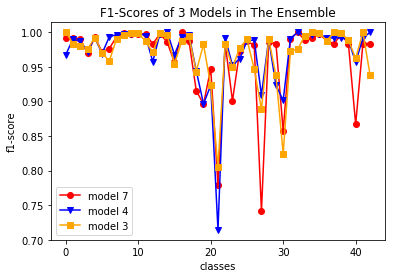

In [11]:
# F1-scores of 3 models with the best model
paths = [
    './saved-salexnet-aug-eq-n-ens7/best-test-f1-scores.pkl',
    './saved-salexnet-aug-eq-n-ens4/best-test-f1-scores.pkl',
    './saved-salexnet-aug-eq-n-ens3/best-test-f1-scores.pkl'
    ]
classes = np.arange(43)
colors = ['red', 'blue', 'orange']
markers = ['o', 'v', 's']
labels = ['model 7', 'model 4', 'model 3']
for i, path in enumerate(paths):
    with open(path, mode='rb') as f:
        score_list = pickle.load(f)
    plt.plot(classes, score_list,
        marker=markers[i], color=colors[i],
        label=labels[i])
plt.title('F1-Scores of 3 Models in The Ensemble')
plt.ylabel('f1-score')
plt.xlabel('classes')
plt.legend(loc='lower left')
plt.show()
plt.close()

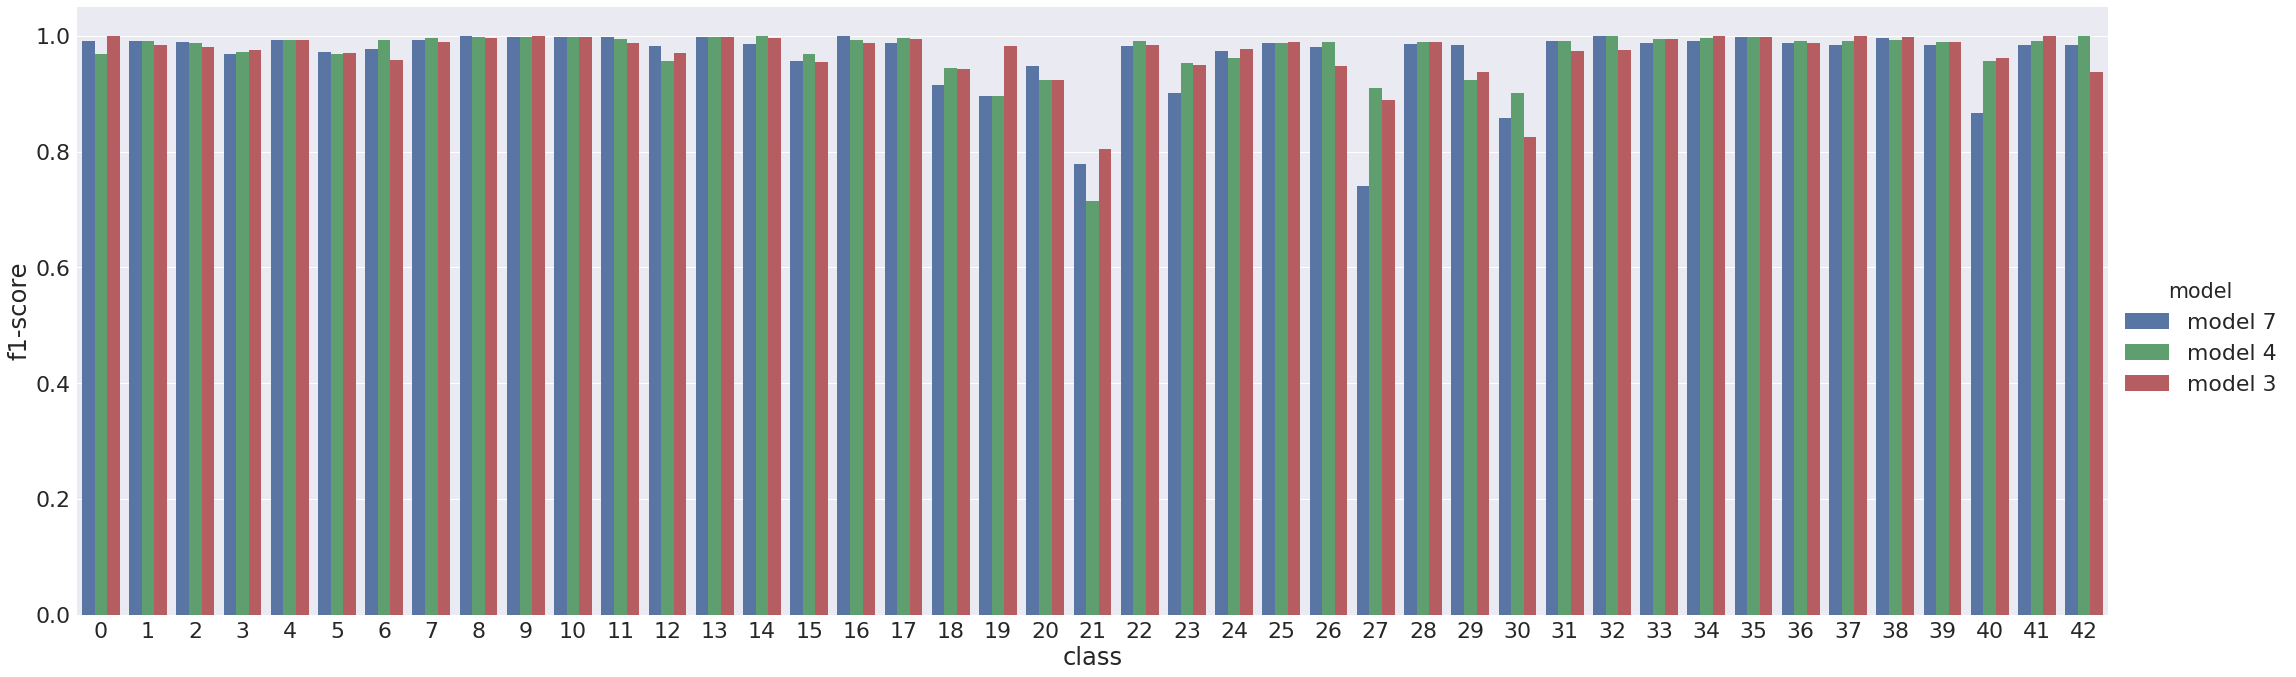

In [41]:
# plot f1 scores with boxes
paths = [
    './saved-salexnet-aug-eq-n-ens7/best-test-f1-scores.pkl',
    './saved-salexnet-aug-eq-n-ens4/best-test-f1-scores.pkl',
    './saved-salexnet-aug-eq-n-ens3/best-test-f1-scores.pkl'
    ]
dfs = []
types = ['model 7', 'model 4', 'model 3']
for i, path in enumerate(paths):
    with open(path, mode='rb') as f:
        scores = pickle.load(f)
        dfs.append(pd.DataFrame({
            'f1-score': scores,
            'model': types[i],
            'class': np.arange(len(scores))
            }))
df = pd.concat(dfs)

sns.set(font_scale=2.2)
sns.factorplot(x='class', y='f1-score',
    hue='model', data=df,
    kind='bar', size=10,
    aspect=3)
plt.show()
plt.close()